In [1]:
from pathlib import Path
import os
import sys

main_directory = Path(os.path.abspath("")).parent
sys.path.append(str(main_directory))

## Create a JSSP problem instance

In [2]:
from queasars.job_shop_scheduling.problem_instances import Machine, Operation, Job, JobShopSchedulingProblemInstance

machines = (Machine(name="m1"), Machine(name="m2"), Machine(name="m3"))

j1op1 = Operation(name="op1", job_name="j1", machine=machines[0], processing_duration=1)
j1op2 = Operation(name="op2", job_name="j1", machine=machines[1], processing_duration=1)
j1op3 = Operation(name="op3", job_name="j1", machine=machines[2], processing_duration=1)
job1 = Job(name="j1", operations=(j1op1, j1op2, j1op3))

j2op1 = Operation(name="op1", job_name="j2", machine=machines[2], processing_duration=1)
j2op2 = Operation(name="op2", job_name="j2", machine=machines[1], processing_duration=1)
j2op3 = Operation(name="op3", job_name="j2", machine=machines[0], processing_duration=1)
job2 = Job(name="j2", operations=(j2op1, j2op2, j2op3))

j3op1 = Operation(name="op1", job_name="j3", machine=machines[1], processing_duration=1)
j3op2 = Operation(name="op2", job_name="j3", machine=machines[2], processing_duration=1)
job3 = Job(name="j3", operations=(j3op1, j3op2))

jssp_instance = JobShopSchedulingProblemInstance(name="jssp1", machines=machines, jobs=(job1, job2, job3))

print(jssp_instance)

jssp1
  Machines:
    m1
    m2
    m3
  Jobs:
    j1:
      j1_op1(m1, 1)
      j1_op2(m2, 1)
      j1_op3(m3, 1)
    j2:
      j2_op1(m3, 1)
      j2_op2(m2, 1)
      j2_op3(m1, 1)
    j3:
      j3_op1(m2, 1)
      j3_op2(m3, 1)



## Visualize the created problem instance (optional)

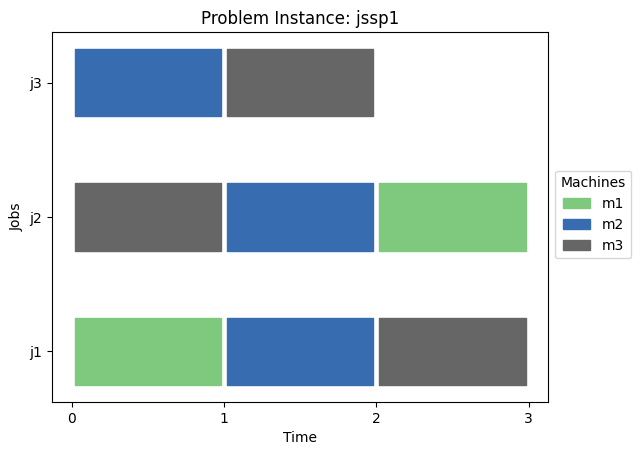

In [3]:
from queasars.job_shop_scheduling.visualization import plot_jssp_problem_instance_gantt

plot = plot_jssp_problem_instance_gantt(problem_instance=jssp_instance)

## Convert the problem instance to a hamiltonian

In [4]:
from queasars.job_shop_scheduling.domain_wall_hamiltonian_encoder import JSSPDomainWallHamiltonianEncoder

encoder = JSSPDomainWallHamiltonianEncoder(jssp_instance=jssp_instance, makespan_limit=4, max_opt_value=100, opt_all_operations_share=0.19, encoding_penalty=319, overlap_constraint_penalty=319, precedence_constraint_penalty=275)

print("needed qubits: ", encoder.n_qubits)

hamiltonian = encoder.get_problem_hamiltonian()

needed qubits:  10


## Setup the configuration for the EVQEMinimumEigensolver

In [5]:
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.optimizers import SPSA

from dask.distributed import LocalCluster

from queasars.minimum_eigensolvers.base.termination_criteria import BestIndividualRelativeChangeTolerance
from queasars.utility.spsa_termination import SPSATerminationChecker
from queasars.minimum_eigensolvers.evqe.evqe import EVQEMinimumEigensolverConfiguration

# The EVQEMinimumEigensolver needs at least a sampler and can also use an estimator.
# Here we only use a sampler, as the Critical Value at Risk objective value can
# can only be used when only using the sampler.
sampler_primitive = Sampler()
estimator_primitive = None

# If only a sampler is used, the expectation value with respect to the Hamiltonian
# is calculated using the measurement distribution provided by the sampler. This
# expectation value can also be calculated over only the lower tail of that distribution.
# In that case the objective score is also called the Critical Value at Risk.
distribution_alpha_tail = 0.5

# The EVQEMinimumEigensolver also needs a qiskit optimizer. It should be
# configured to terminate quickly, so that mutations are not overtly expensive.
# Here we use the SPSA optimizer with a very limited amount of iterations and a
# large step size.
termination_checker = SPSATerminationChecker(minimum_relative_change=0.01, allowed_consecutive_violations=2)
optimizer = SPSA(maxiter=33, perturbation=0.35, learning_rate=0.43, trust_region=True, last_avg=1, resamplings=1, termination_checker=termination_checker.termination_check)

# To help the EVQEMinimumEigensolver deal correctly with terminations based
# on the amount of circuit evaluations used, an estimate can be given for how
# many circuit evaluations the optimizer uses per optimization run.
# SPSA makes two measurements per gradient approximation, which means in total it will
# need 66 circuit evaluations for 33 iterations.
optimizer_n_circuit_evaluations = 66

# To specify when the EVQEMinimumEigensolver should terminate either max_generations,
# max_circuit_evaluations or a termination_criterion should be given.
max_generations = None
max_circuit_evaluations = None
termination_criterion = BestIndividualRelativeChangeTolerance(minimum_relative_change=0.01, allowed_consecutive_violations=1)

# A random seed can be provided to control the randomness of the evolutionary process.
random_seed = None

# The population size determines how many individuals are evaluated each generation.
# With a higher population size, fewer generations might be needed, but this also
# makes each generation more expensive to evaluate. A reasonable range might be
# 10 - 100 individuals per population.
population_size = 10

# The initial individuals in the starting population can be initialized with
# an arbitrary amount of layers and fully randomized parameter values. This
# can be particularly useful if the state |0 .. 0> is a local minima and
# the individuals should not start in that state
n_initial_layers = 2
randomize_initial_parameter_values = True

# Determines how many circuit layers apart two individuals need to be, to be considered to
# be of a different species. Reasonable values might be in the range 1 - 5.
speciation_genetic_distance_threshold = 1

# This implementation of EVQE offers both roulette wheel selection and tournament selection.
# Since tournament selection is more robust, we use it here.
use_tournament_selection = True
tournament_size = 2

# The alpha and beta penalties penalize quantum circuits of increasing depth (alpha) and
# increasing amount of controlled rotations (beta). increase them if the quantum circuits get to
# deep or complicated.
selection_alpha_penalty = 0.15
selection_beta_penalty = 0.02

# The parameter search probability determines how likely an individual is mutated by optimizing
# all it's parameter values. This should not be too large as this is costly.
parameter_search_probability = 0.39

# The topological search probability determines how likely a circuit layer is added to an individual
# as a mutation.
topological_search_probability = 0.79

# The layer removal probability determines how likely circuit layers are removed from an individual
# as a mutation. This is a very disruptive mutation and should only be used sparingly to counteract
# circuit growth.
layer_removal_probability = 0.02

# An executor for launching parallel computation can be specified.
# This can be a dask Client or a python ThreadPoolExecutor. If None is
# specified a ThreadPoolExecutor with population_size many threads will
# be used
parallel_executor = LocalCluster(n_workers=10, processes=True, threads_per_worker=1).get_client()

# Discerns whether to only allow mutually exclusive access to the Sampler and
# Estimator primitive respectively. This is needed if the Sampler or Estimator are not threadsafe and
# a ThreadPoolExecutor with more than one thread or a Dask Client with more than one thread per process is used.
# For safety reasons this is enabled by default. If the sampler and estimator are threadsafe disabling this
# option may lead to performance improvements
mutually_exclusive_primitives = False

configuration = EVQEMinimumEigensolverConfiguration(
    sampler=sampler_primitive,
    estimator=estimator_primitive,
    distribution_alpha_tail=distribution_alpha_tail,
    optimizer=optimizer,
    optimizer_n_circuit_evaluations=optimizer_n_circuit_evaluations,
    max_generations=max_generations,
    max_circuit_evaluations=max_circuit_evaluations,
    termination_criterion=termination_criterion,
    random_seed=random_seed,
    population_size=population_size,
    n_initial_layers=n_initial_layers,
    randomize_initial_population_parameters=randomize_initial_parameter_values,
    speciation_genetic_distance_threshold=speciation_genetic_distance_threshold,
    use_tournament_selection=use_tournament_selection,
    tournament_size=tournament_size,
    selection_alpha_penalty=selection_alpha_penalty,
    selection_beta_penalty=selection_beta_penalty,
    parameter_search_probability=parameter_search_probability,
    topological_search_probability=topological_search_probability,
    layer_removal_probability=layer_removal_probability,
    parallel_executor=parallel_executor,
    mutually_exclusive_primitives=mutually_exclusive_primitives,
)

## Setup the EVQEMinimumEigensolver

In [6]:
from queasars.minimum_eigensolvers.evqe.evqe import EVQEMinimumEigensolver

eigensolver = EVQEMinimumEigensolver(configuration=configuration)

## Solve the problem as posed in the hamiltonian

In [7]:
import logging

logger = logging.getLogger("queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver")
handler = logging.StreamHandler()
logger.setLevel(logging.INFO)
logger.addHandler(handler)

result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)
quasi_distribution = result.eigenstate.binary_probabilities()


Starting evolution!
Results for generation: 0
Current best expectation value: 237.317285
Current median expectation value: 625.911890
Current average expectation value: 1154.255593
Results for generation: 1
Current best expectation value: 39.237500
Current median expectation value: 131.527307
Current average expectation value: 151.810347
Results for generation: 2
Current best expectation value: 39.237500
Current median expectation value: 39.237500
Current average expectation value: 41.661514
Results for generation: 3
Current best expectation value: 39.237500
Current median expectation value: 39.237500
Current average expectation value: 39.257539


## Plot the distribution

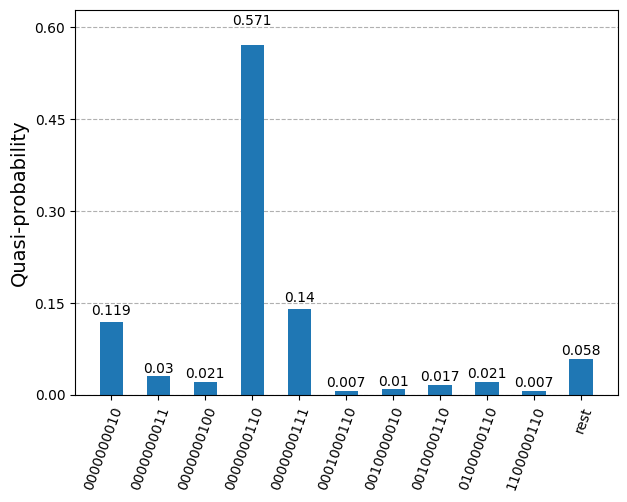

In [8]:
from qiskit.visualization import plot_distribution

plot_distribution(quasi_distribution, number_to_keep=10)

## use the encoder to retrieve the solution

In [9]:
solutions = []
for bitstring, probability in quasi_distribution.items():
    if probability < 0.05:
        continue

    solution = encoder.translate_result_bitstring(bitstring=bitstring)

    print("probability: ", probability, "is valid: ", solution.is_valid)
    print(solution)
    if solution.is_valid:
        solutions.append(solution)

probability:  0.5712890625 is valid:  True
jssp1 solution with makespan 4
  j1:
    j1_op1(m1, 1) starts at: 0 and ends at: 1
    j1_op2(m2, 1) starts at: 2 and ends at: 3
    j1_op3(m3, 1) starts at: 3 and ends at: 4
  j2:
    j2_op1(m3, 1) starts at: 0 and ends at: 1
    j2_op2(m2, 1) starts at: 1 and ends at: 2
    j2_op3(m1, 1) starts at: 2 and ends at: 3
  j3:
    j3_op1(m2, 1) starts at: 0 and ends at: 1
    j3_op2(m3, 1) starts at: 1 and ends at: 2

probability:  0.1396484375 is valid:  True
jssp1 solution with makespan 4
  j1:
    j1_op1(m1, 1) starts at: 1 and ends at: 2
    j1_op2(m2, 1) starts at: 2 and ends at: 3
    j1_op3(m3, 1) starts at: 3 and ends at: 4
  j2:
    j2_op1(m3, 1) starts at: 0 and ends at: 1
    j2_op2(m2, 1) starts at: 1 and ends at: 2
    j2_op3(m1, 1) starts at: 2 and ends at: 3
  j3:
    j3_op1(m2, 1) starts at: 0 and ends at: 1
    j3_op2(m3, 1) starts at: 1 and ends at: 2

probability:  0.119140625 is valid:  False
jssp1 solution with makespan None
 

## Visualize the result (optional)

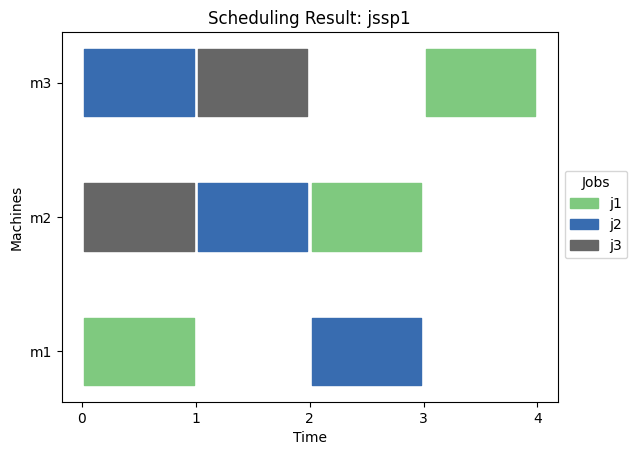

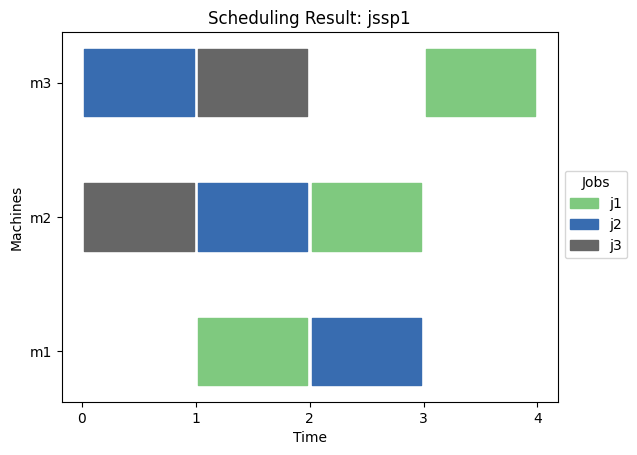

In [10]:
from queasars.job_shop_scheduling.visualization import plot_jssp_problem_solution_gantt

for solution in solutions:
    plot = plot_jssp_problem_solution_gantt(result=solution)